In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from ForecastSimulator import Forecastsimulator, forecast_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from xgboost import XGBRFRegressor, XGBRegressor
from pandas_datareader import data as web

plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['axes.labelsize'] = 15

Let's try to predict stocks of Louis Vuitton
<br>
First task retrieve data

In [2]:
data = pd.DataFrame(web.DataReader('0HAU.UK', 'stooq', '2018'))
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1246 entries, 2022-11-09 to 2018-01-02
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1246 non-null   float64
 1   High    1246 non-null   float64
 2   Low     1246 non-null   float64
 3   Close   1246 non-null   float64
 4   Volume  1243 non-null   float64
dtypes: float64(5)
memory usage: 58.4 KB


In [3]:
close = data[['Close']]
close = close.sort_index(ascending = True)
close

,Close
Date,
2018-01-02,238.906
2018-01-03,240.216
2018-01-04,243.059
2018-01-05,245.654
2018-01-08,242.910
...,...
2022-11-03,628.450
2022-11-04,664.050
2022-11-07,655.150


Easily done thanks to python modules

<AxesSubplot: xlabel='Date'>

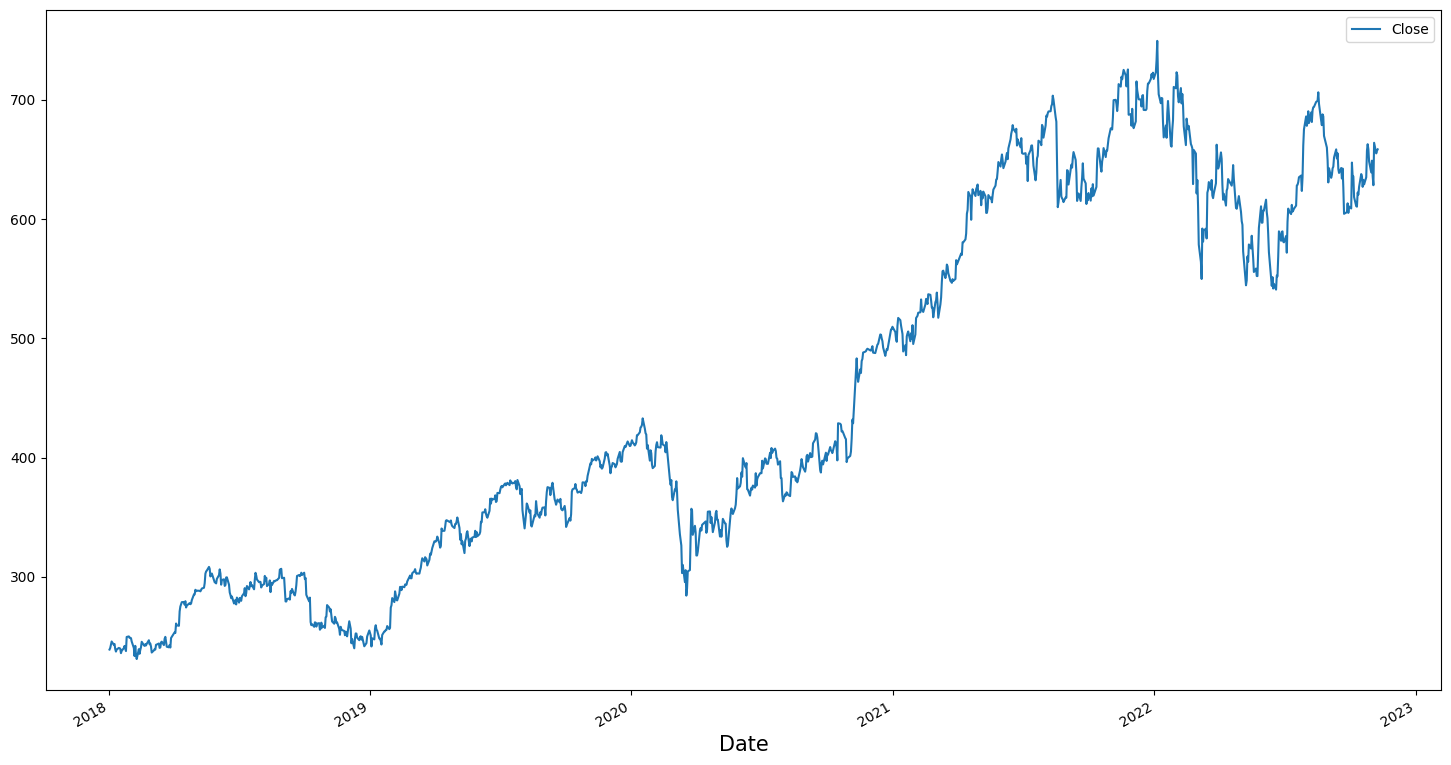

In [4]:
close.plot()

After a quick view of the data we need to reshape them
<br>
We will take in account a window_size of 60 days so data will have in the end a shape of (rows-window_size, window_size)
<br>
To elaborate the result and a strategy for trading I created a class named ForecastSimulator which will simulate a day by day trading of the closure value of a stock
<br>
Also we want to create a test set which will be the last year recorded

In [5]:
X_train, X_test, y_train, y_test = forecast_split(close, test_days=365, dtp=1, window_size=60)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

The model used will be a XGBoost, let's try a gridsearch and simulate an investment strategy which will be discussed later

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 110}


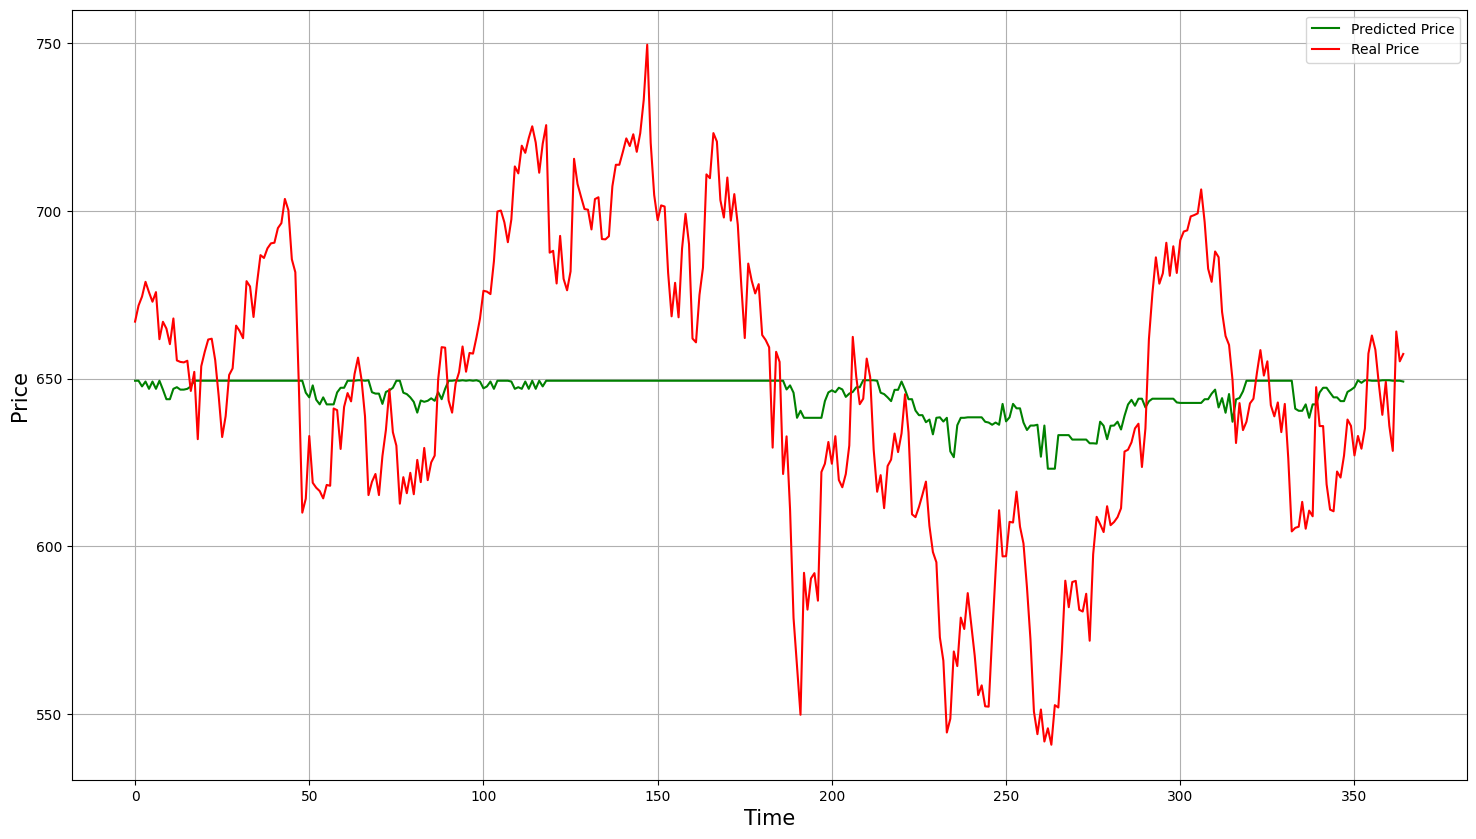

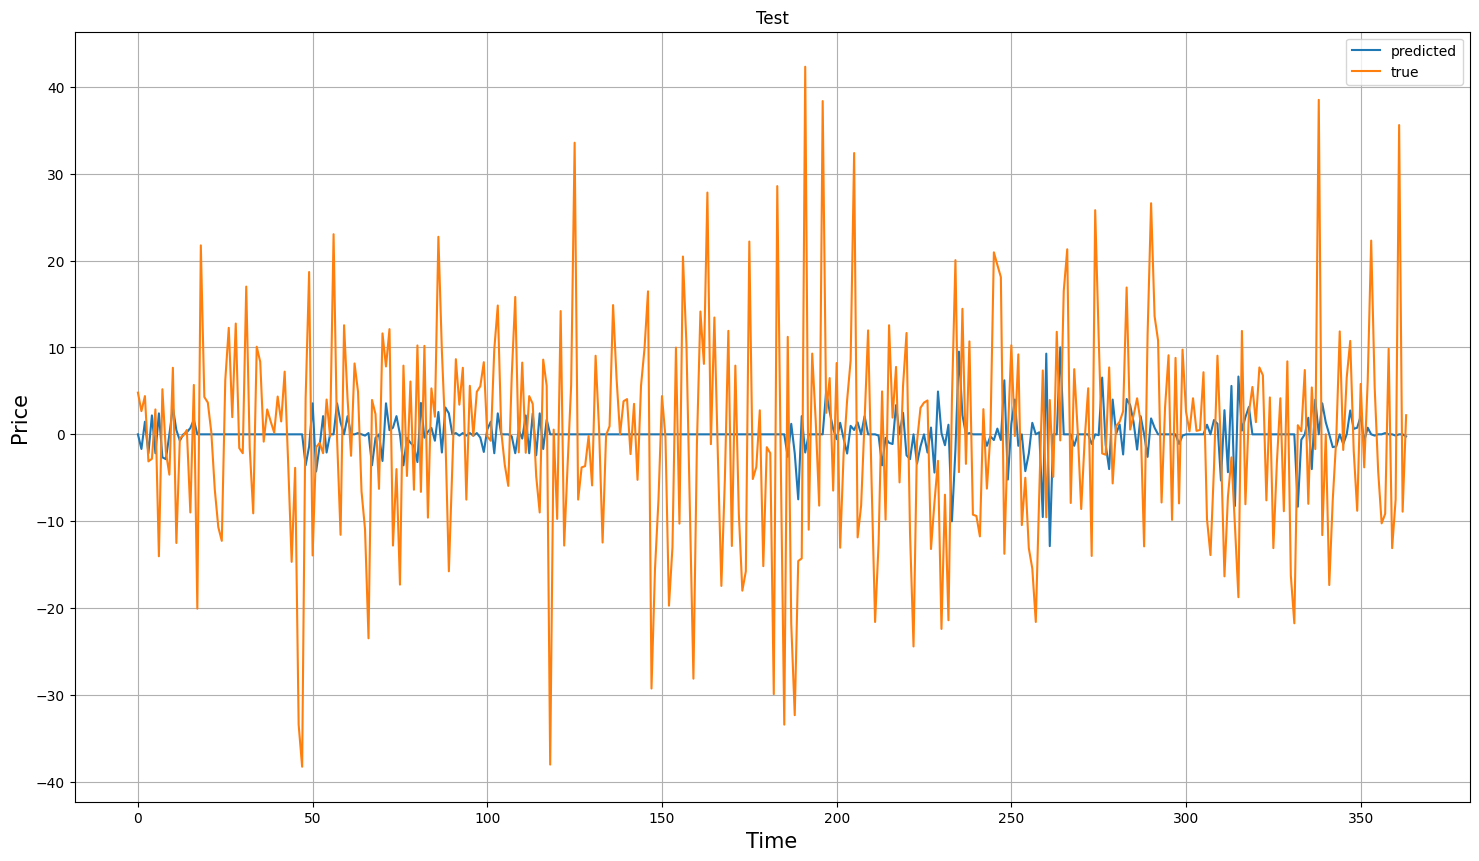

0.45454545454545453


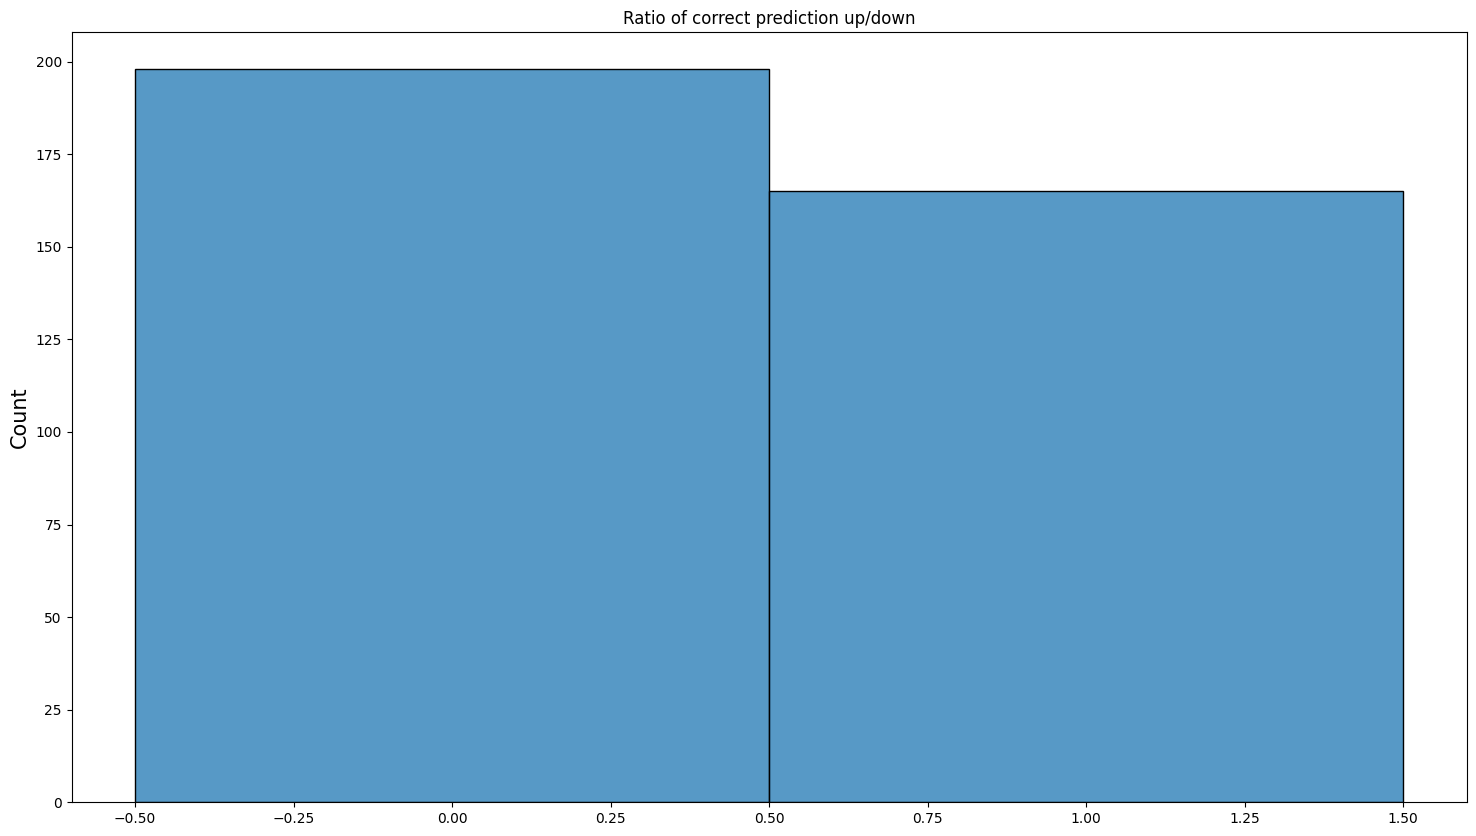

-0.16750520160652635 1.8763415817012457


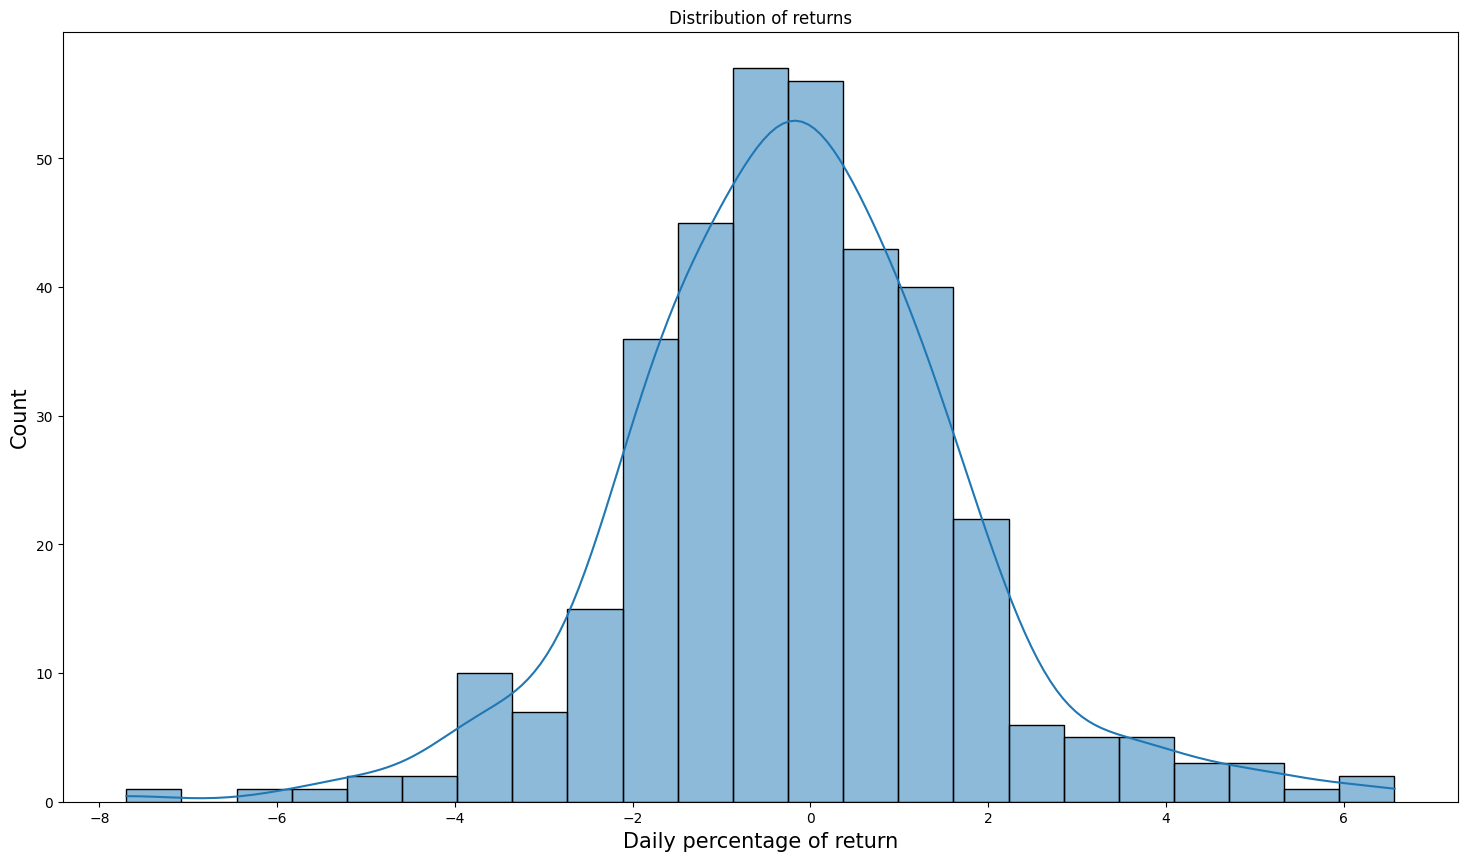

-121.60877636633813


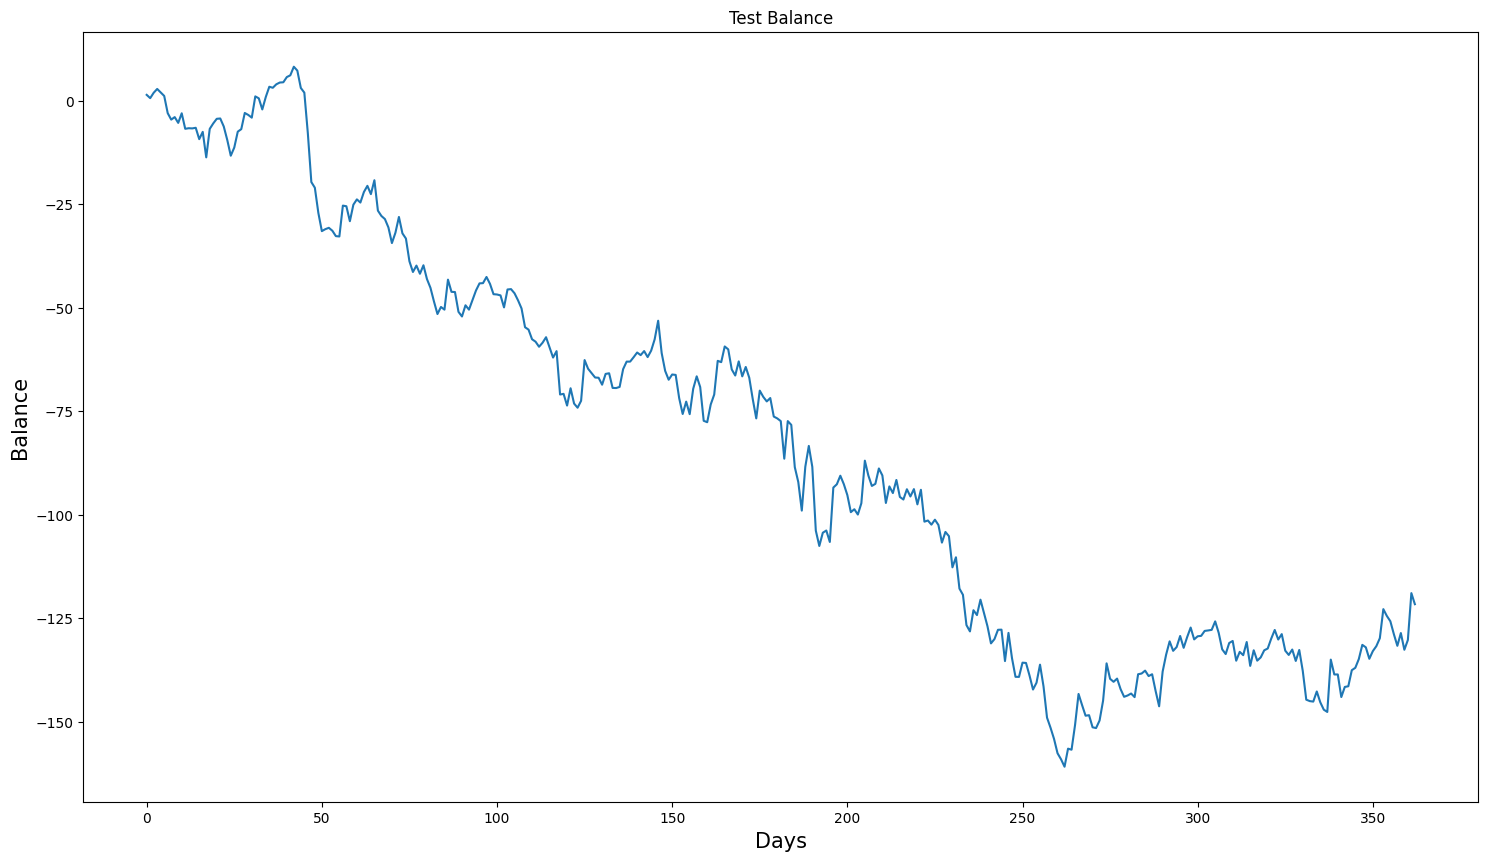

In [6]:
params = {'n_estimators':[i for i in range(50, 121, 10)],
          "max_depth": [3, 4, 5, 7],
          "learning_rate": [0.5, 0.1, 0.05, 0.01],
         }

grid = GridSearchCV(XGBRegressor(), param_grid=params, n_jobs=-1)

#check the class for more info
fs2 = Forecastsimulator(grid)
model = fs2.train(X_train_scaled, y_train_scaled)
print(f'Best parameters: {model.best_params_}')
prediction = scaler_y.inverse_transform(fs2.predict(X_test_scaled).reshape(-1,y_test.shape[1]))

#check the class for more info
fs2.plot_prediction(prediction, y_test)
fs2.simulate(prediction, y_test)
params = grid.best_params_

The idea is to bet on an increase or a decrease of stock closure price the day before for the following day.
<br>
If the derivative of the predicted values has the same sign of the derivative of the real stock price (with matching days obviously) then we gain the variation percentage of the stock, otherwise we lose the amount.
<br>
As you can see from the various graph the model isn't doing really good, but that is expected, because markets are not stationary series, and we didn't retrain the model for a whole year.
<br>
At the end of the year we lost 121 euros trading every day 200 euros, having an average loss of -0.16% per day.
<br>
Fortunately the class ForecastSimulator has the method 'retrain' which retrain the model with the update data every specified interval (thanks me).
<br>
Let's try to retrain the model every 7 days and evaluate our trading strategy

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

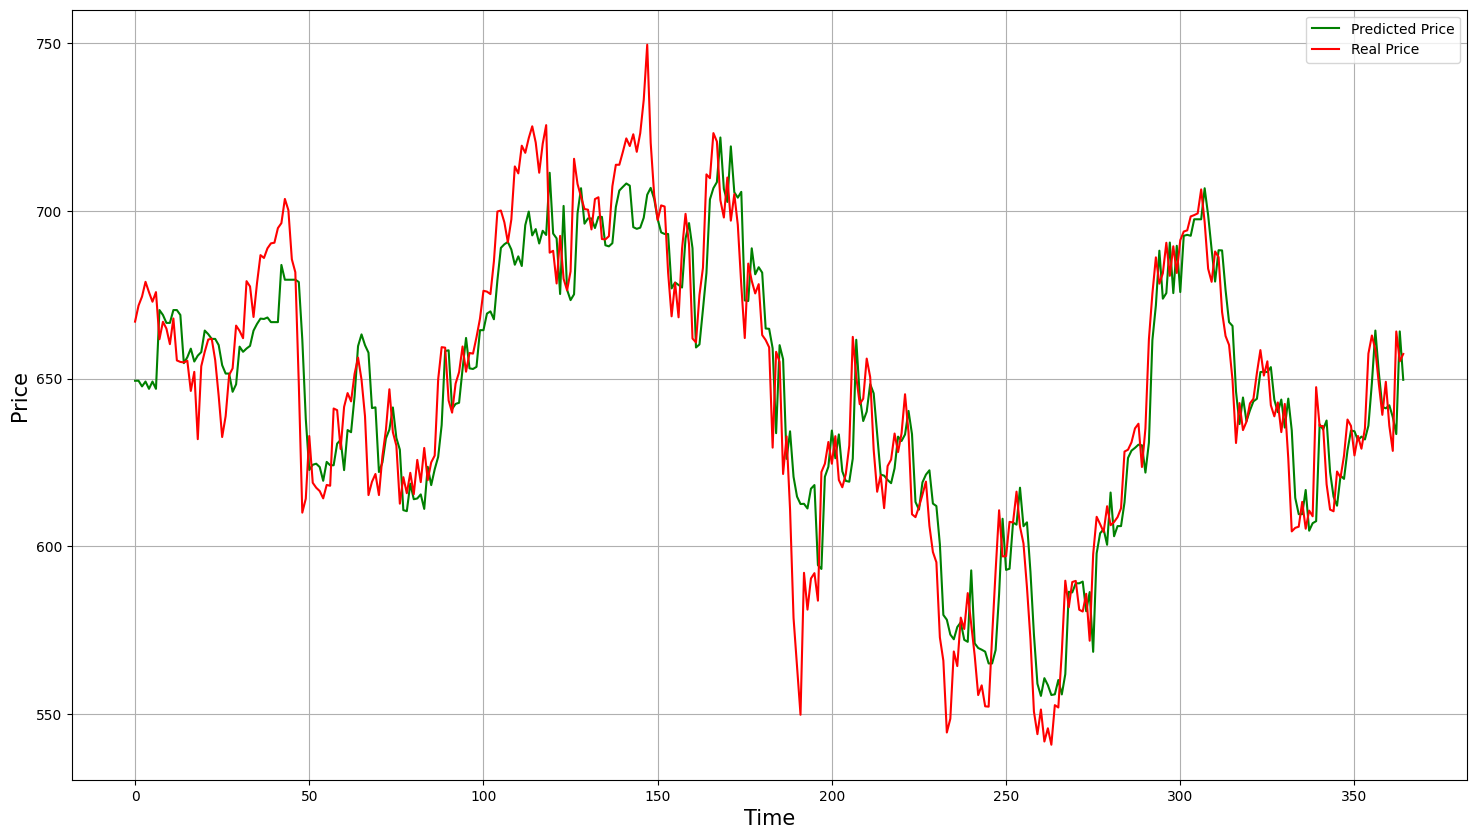

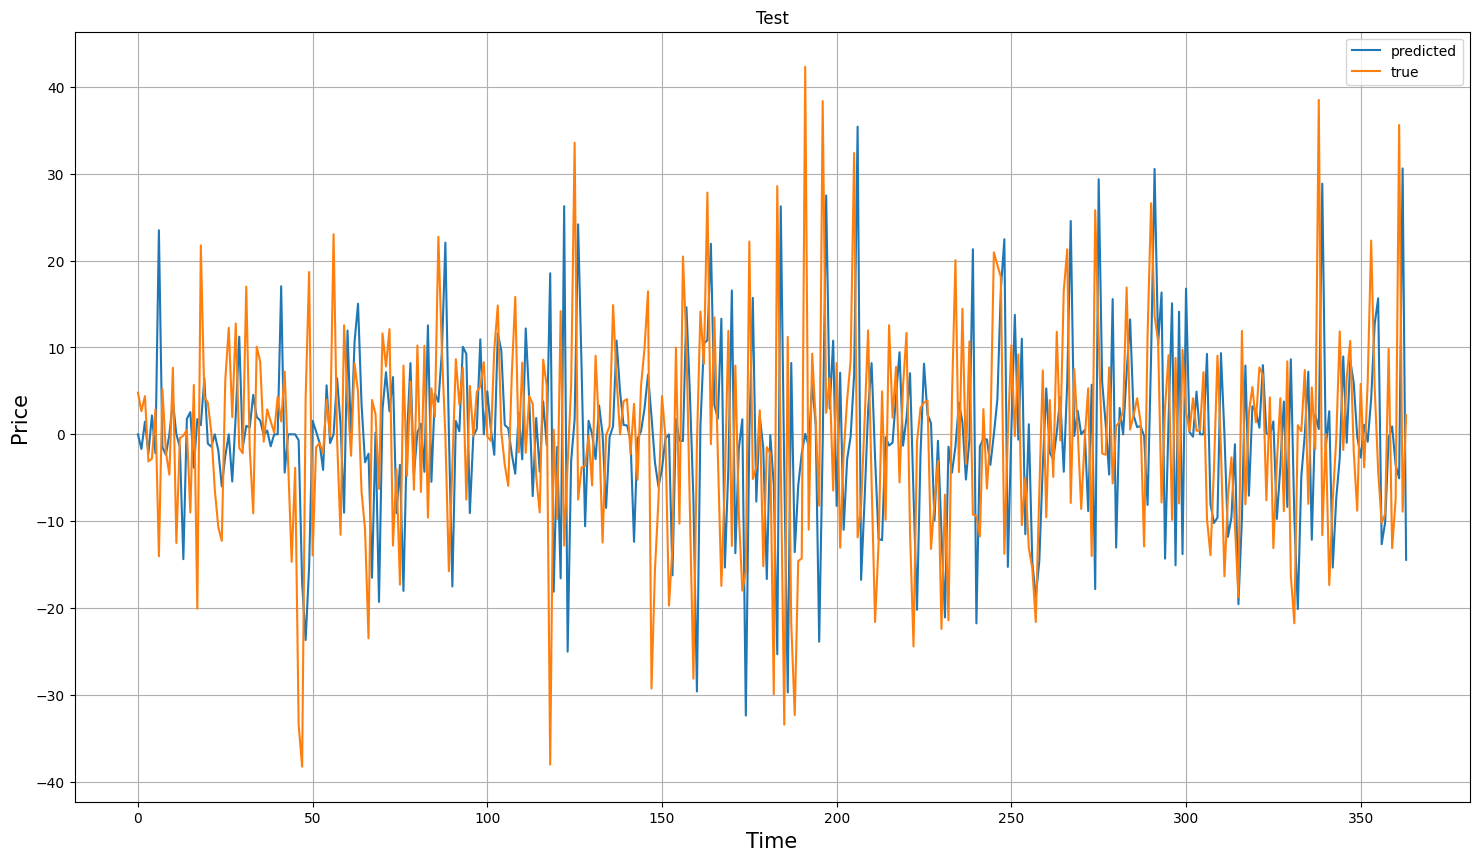

0.5234159779614325


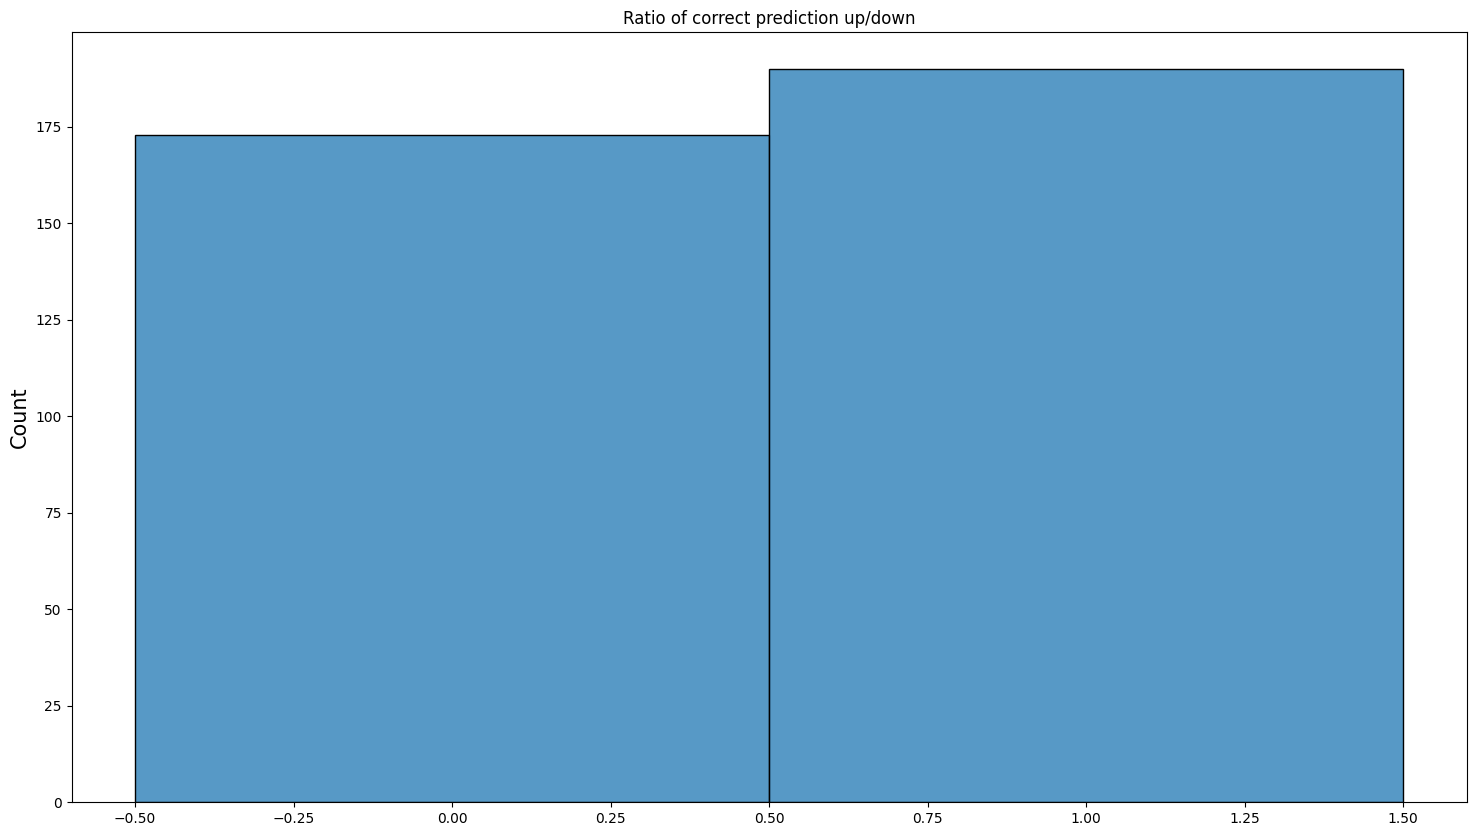

0.18171578444144112 1.8750186925658119


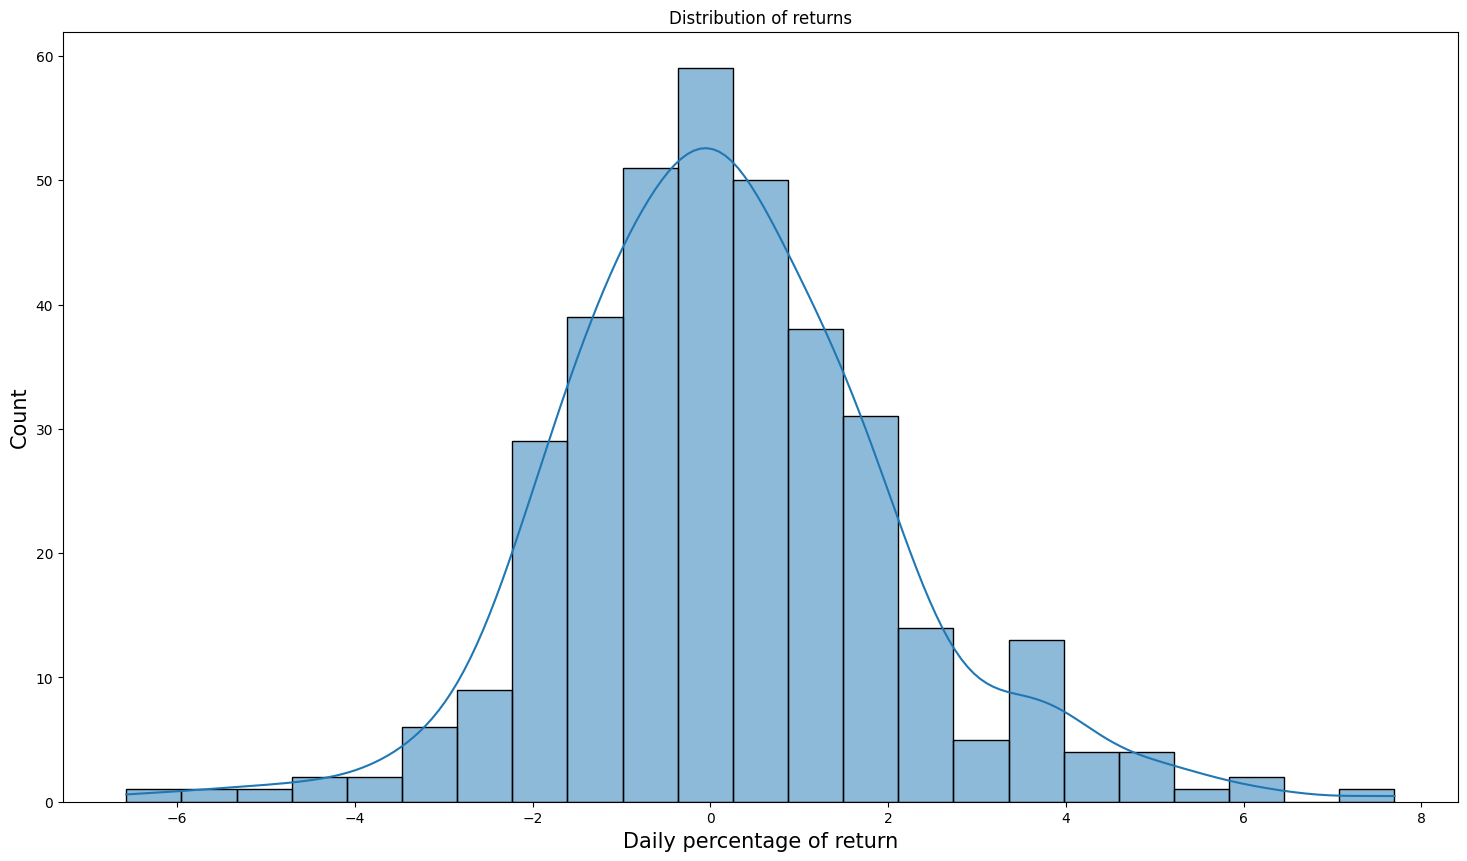

131.92565950448625


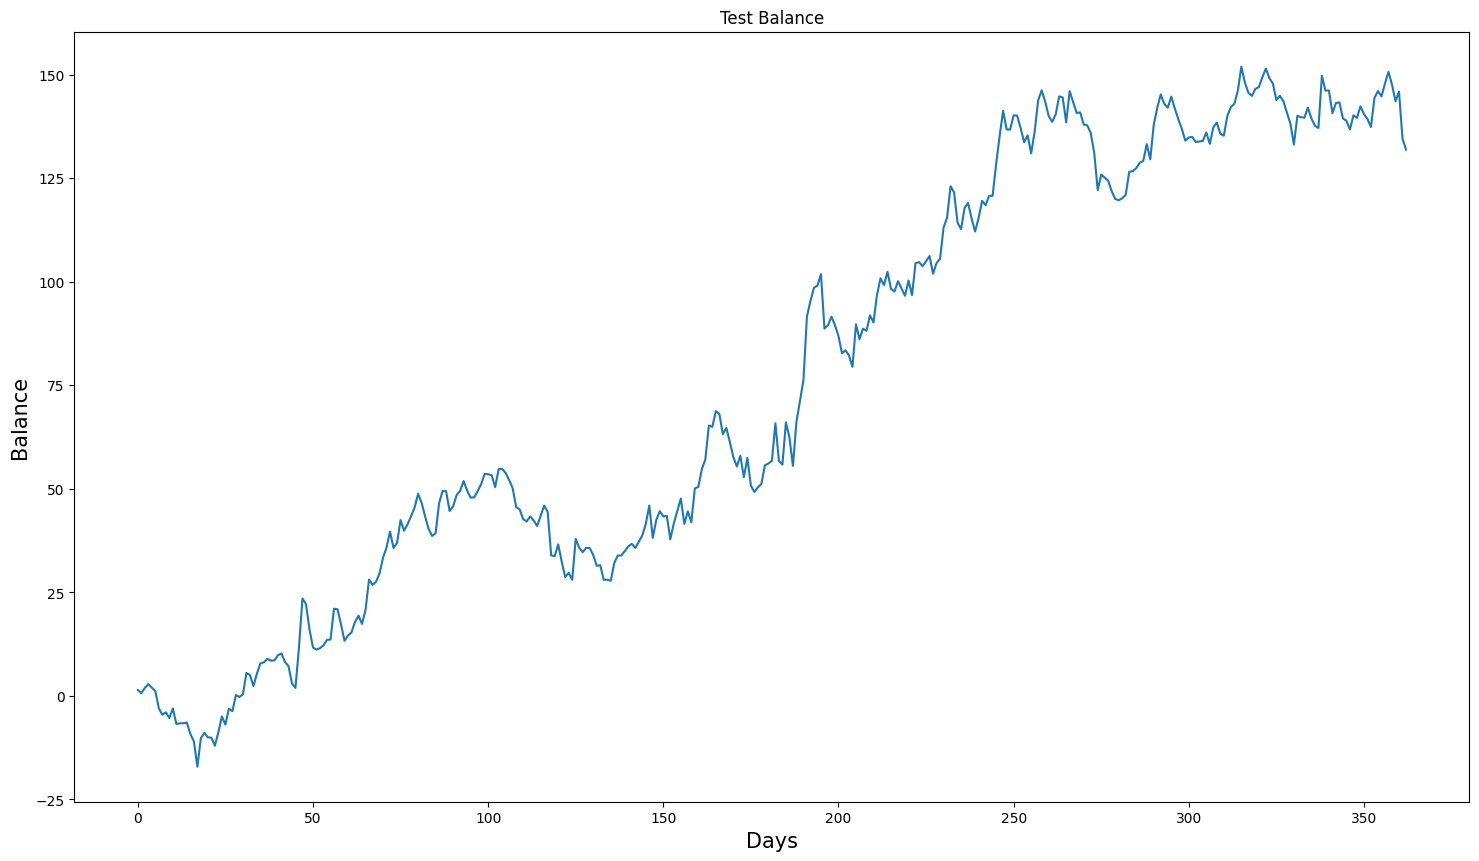

In [7]:
fs2 = Forecastsimulator(XGBRegressor(**params))
pred = fs2.retrain(XGBRegressor(**params), X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, retrain_period=7)
prediction = scaler_y.inverse_transform(pred)

fs2.plot_prediction(prediction, y_test)
fs2.simulate(prediction, y_test)

As we can see this is much better, we are gaining 0.18% of the trade every day on average.
<br> 
This is translated in 65% return over a year, which is equivalent to 131 euros in this case.
<br>
Withouth much effort we already reached a good result.
<br>
To be honest I would use neural networks for forecasting tasks. They have more return and they are more solid respect to arbitrary parameters such as window_size.
<br>
Another parameter we can set is dtp which means day to predict.
<br>
Changing how many days to predict from a single X row, can improve the performance, in particular if the model looks like 'traslated' respect to stock real values
<br>
That is more marked with neural networks
<br>
For now I won't share the real project with neural networks, if you are interested in it feel free to contact me.